In [96]:
email_reply = 'Dear Dr. Peter Schindler, \nHappy new year to you, Sir. \nIn the lines of codes below, I will be demonstrating an application of Machne Learning workflow to a Materials Science data. The data is related to inorganic materials and their band gaps.'
print(email_reply)

Dear Dr. Peter Schindler, 
Happy new year to you, Sir. 
In the lines of codes below, I will be demonstrating an application of Machne Learning workflow to a Materials Science data. The data is related to inorganic materials and their band gaps.


In [102]:
%%html
<p>My apologies for taking so long to respond; I encountered a few technical issues with the data I had to work with. I needed to install updated versions of the Python library, but my computer wasn't compatible with some of them. As a result, I had to figure out a workaround to manually address the functionality.</p>
<a href="default.asp" target="_blank">Thank you so much, Sir.</a></b></p>

# Problem Statement

The viability of solar power as a renewable energy source can be increased by lowering the cost of production materials and improving the efficiency of the Solar Cells. If this can be achieved by discovering new, cheaper materials and ones with ideal band gaps, then solar energy could grow more quickly. To begin with, we should aim to build a model that can predict potential solar materials based on their band gap, limiting ourselves to single-junction cells. The band gap for these cells should be between 1.0 and 1.7 eV, requiring a model that can be accurate within +- 0.35 eV. Additionally, there are semi-conductor devices known as Wide Band Gap semi-conductors (WBG), which can improve the efficiency of industrial motors, LED lighting, lasers and other electronics. To accelerate the development of these devices, we need to build a model to predict WBG materials with a band gap of between 2 and 4 eV, needing an accuracy of +- 1 eV.

In [1]:
#import neccessary python library
import os                        # OS stands for Operating System and provides ways for python to interact with files or directories
from collections import Counter  # Collections is a package for handling data
from pprint import pprint

import pandas as pd              # Pandas is a data analysis library which we'll primarily use to handle our dataset
import numpy as np               # Numpy is a package for scientific computing. We'll use it for some of it's math functions
import pymatgen                  # Pymatgen is a library for materials analysis which we use to interpret our material compositions

In [2]:
import matplotlib                # Matplotlib is the plotting package that we'll use throughout the lab
import matplotlib.pyplot as plt
import seaborn as sns         
# Seaborn is a Python data visualization library based on matplotlib

In [3]:
import sklearn                   # Scikit-learn is a machine learning package, providing the backbone for the work we'll perform
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate,GridSearchCV,ParameterGrid
from sklearn.model_selection import KFold,RepeatedKFold

In [4]:
import graphviz                  # graphviz is a package that helps visualize decision trees

In [5]:
from helper_functions import *

In [6]:
seed = 2345312

In [7]:
# Read in the band gap data from our dataset

PATH = os.getcwd() #pwd=present working diretory. Permitting python to interact with the files and get the current working directories (getcwd)
data_path = os.path.join(PATH, 'bandgap_data_v2.csv') #defining the file path
ope_df = pd.read_csv(data_path)

In [8]:
ope_df

,index,chemicalFormula Clean,Band gap values Clean,Band gap units,Band gap method,Reliability
0,0,Li1F1,13.60,eV,Reflection,1
1,1,Li1F1,12.61,eV,Reflection,1
2,2,Li1F1,12.60,eV,Estimated,2
3,3,Li1F1,12.10,eV,Absorption,2
4,4,Li1F1,12.00,eV,Absorption,2
...,...,...,...,...,...,...
1442,1454,Th1O2,3.30,eV,Reflection,2
1443,1455,UO,1.50,eV,Thermal activation,1
1444,1456,U1O2,2.18,eV,Absorption,1
1445,1457,UO,0.60,eV,Thermal activation,2


In [10]:
ope_df.drop(columns=['Band gap units','Band gap method','index'], axis=1,inplace=True)

In [11]:
# Filter for only Reliability 1
ope_df_filtered = ope_df[mastml_df["Reliability"]==1]

In [12]:
# Print filtered data
ope_df_filtered

,chemicalFormula Clean,Band gap values Clean,Reliability
0,Li1F1,13.600,1
1,Li1F1,12.610,1
6,Li1Cl1,9.330,1
7,Li1Br1,7.950,1
9,Li3Sb1,1.000,1
...,...,...,...
1433,Bi,0.015,1
1436,Th1O2,5.750,1
1437,Th1O2,3.500,1
1443,UO,1.500,1


In [14]:
rename_dict = {'chemicalFormula Clean': 'formula', 'Band gap values Clean': 'bg'}
ope_df_filtered = ope_df_filtered.rename(columns=rename_dict)
ope_df_filtered.columns

Index(['formula', 'bg', 'Reliability'], dtype='object')

I need to find an average for some formulas that have multiple measurements. As I have no other way to determine which data points to keep, I will take the mean of the values from these multiple measurements. To do so, I can take advantage of the groupby function in Pandas, which allows me to group together all of the identical formulas and then derive an average within each group.

In [15]:
ope_df_clean = ope_df_filtered.groupby("formula", as_index = False).mean()
ope_df_clean

,formula,bg,Reliability
0,Ag1Br1,3.485,1.0
1,Ag1Cl1,4.190,1.0
2,Ag1N3,3.900,1.0
3,Ag1Te1,0.850,1.0
4,Ag2O1,1.200,1.0
...,...,...,...
462,Zr1Se2,2.000,1.0
463,Zr1Se3,1.250,1.0
464,Zr3O1,0.200,1.0
465,Zr6O1,0.180,1.0


In [16]:
ope_df_clean.drop(columns=['Reliability'], axis=1,inplace=True)

In [17]:
ope_df_clean

,formula,bg
0,Ag1Br1,3.485
1,Ag1Cl1,4.190
2,Ag1N3,3.900
3,Ag1Te1,0.850
4,Ag2O1,1.200
...,...,...
462,Zr1Se2,2.000
463,Zr1Se3,1.250
464,Zr3O1,0.200
465,Zr6O1,0.180


In [20]:
# generate basic statistics on our band gap values
ope_df_clean["bg"].describe().round(3)

count    467.000
mean       2.231
std        2.287
min        0.009
25%        0.695
50%        1.435
75%        3.000
max       13.105
Name: bg, dtype: float64

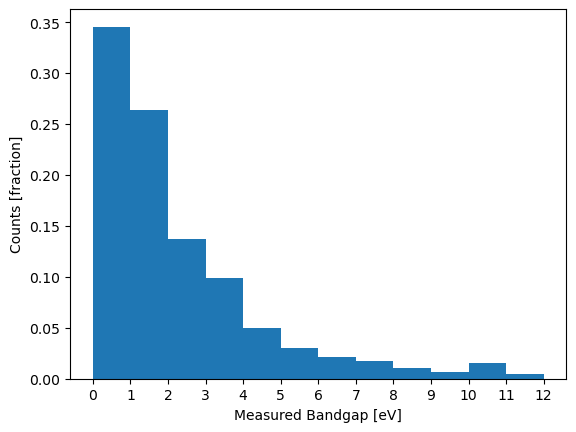

In [21]:
# we'll also define a simple histogram plotting function to use later
def histogram_plot(data):
    fig1,ax1 = plt.subplots()
    ax1.hist(data,bins=range(13),density=1)
    ax1.set_xticks(range(13))
    ax1.set_xlabel('Measured Bandgap [eV]')
    ax1.set_ylabel('Counts [fraction]')
    plt.show()

histogram_plot(ope_df_clean["bg"].astype("float"))

In [22]:
list1 = list()
for i in range(ope_df_clean.shape[0]):
    list2 = list()
    list2.append(ope_df_clean.formula.iloc[i])
    list2.append(ope_df_clean.bg.iloc[i])
    list1.append(list2)
print(list1)

[['Ag1Br1', 3.4850000000000003], ['Ag1Cl1', 4.1899999999999995], ['Ag1N3', 3.9], ['Ag1Te1', 0.85], ['Ag2O1', 1.2], ['Ag2S1', 0.95], ['Ag2Se1', 0.13], ['Ag2Te1', 0.064], ['Al1As1', 2.5], ['Al1B1', 0.82], ['Al1Bi1', 0.4], ['Al1N1', 5.74], ['Al1P1', 2.45], ['Al1Sb1', 1.919], ['Al2O3', 9.7], ['Al2S3', 4.1], ['Al2Se3', 3.1], ['Al2Te3', 2.5], ['As', 1.2], ['As1Br3', 2.6], ['As1I3', 2.29], ['As1Se1', 1.2149999999999999], ['As1Te1', 0.74], ['As2O3', 4.0], ['As2S3', 2.43], ['As2S5', 2.48], ['As2Se3', 1.77], ['As2Te3', 0.48], ['As4S4', 2.4], ['B1', 0.93], ['B1As1', 1.46], ['B1N1', 8.0], ['B1P1', 2.0], ['B1Sb1', 2.6], ['B2O3', 7.0], ['Ba1F2', 9.06], ['Ba1O1', 5.13], ['Ba1S1', 3.88], ['Ba1Se1', 3.6], ['Ba1Te1', 3.4], ['Be1O1', 10.48], ['Be1S1', 4.17], ['Be1Se1', 3.61], ['Be1Te1', 2.89], ['Be3Sb2', 0.67], ['Bi', 0.015], ['Bi1Br3', 2.66], ['Bi1I3', 1.9625], ['Bi2O3', 2.755], ['Bi2S3', 1.2], ['Bi2Se3', 0.21], ['Bi2Te3', 0.145], ['C', 6.244999999999999], ['C1Br4', 3.7], ['C1I4', 2.26], ['Ca1B6', 4.5],

In [23]:
# Import the package and the generate_features function
from CBFV.composition import generate_features

In [48]:
df_cbfv=pd.DataFrame(list1, columns = ['formula', 'target'])
X_cbfv, y_cbfv, formulae, skipped = generate_features(df_cbfv, elem_prop='oliynyk', drop_duplicates=False, extend_features=True, sum_feat=True)

Processing Input Data: 100%|██████████| 467/467 [00:00<00:00, 7749.81it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 467/467 [00:00<00:00, 2666.80it/s]


	Creating Pandas Objects...


In [50]:
X_cbfv.head(3)

,sum_Atomic_Number,sum_Atomic_Weight,sum_Period,sum_group,sum_families,sum_Metal,sum_Nonmetal,sum_Metalliod,sum_Mendeleev_Number,sum_l_quantum_number,...,mode_polarizability(A^3),mode_Melting_point_(K),mode_Boiling_Point_(K),mode_Density_(g/mL),mode_specific_heat_(J/g_K)_,mode_heat_of_fusion_(kJ/mol)_,mode_heat_of_vaporization_(kJ/mol)_,mode_thermal_conductivity_(W/(m_K))_,mode_heat_atomization(kJ/mol),mode_Cohesive_energy
0,82.0,187.77220,9.0,28.0,12.0,1.0,1.0,0.0,160.0,1.0,...,3.1,265.95,331.95,3.12000,0.235,5.2860,15.4380,0.12200,112.0,1.22
1,64.0,143.32090,8.0,28.0,12.0,1.0,1.0,0.0,159.0,1.0,...,2.2,172.15,238.55,0.00321,0.235,3.2300,10.2000,0.00890,121.0,1.40
2,68.0,149.88842,11.0,56.0,25.0,1.0,3.0,0.0,311.0,3.0,...,1.1,63.25,77.35,0.00125,1.040,0.3604,2.7928,0.02598,473.0,4.92


In [51]:
cwd = os.getcwd()                                             # get current working directory
conf_path = os.path.join(cwd,"generate_features.conf") # define path of configuration file
csv_path = os.path.join(cwd,"bandgap_data_v3.csv")    # define path of input data
output_path = os.path.join(cwd,"generated_features")   # define output directory to store generated features

In [52]:
# get a new dataframe of generated features from the pregenerated matml run.
generated_features_path = os.path.join(cwd,"generated_features.csv")
features_df = pd.read_csv(generated_features_path)

In [53]:
#split features_df into two dataframes
target_data_df = pd.DataFrame([features_df["chemicalFormula Clean"],features_df["Band gap values Clean"],features_df["Band gap units"],features_df["index"],features_df["Reliability"]]).T
features_df = features_df.drop(columns=['index','Reliability','Band gap values Clean','Band gap units','chemicalFormula Clean'])

In [54]:
target_data_df # our original dataset with inputs and outputs

,chemicalFormula Clean,Band gap values Clean,Band gap units,index,Reliability
0,Li1F1,13.105,eV,0,1
1,Li1Cl1,9.33,eV,6,1
2,Li1Br1,7.95,eV,7,1
3,Li3Sb1,1.0,eV,9,1
4,Li1I1,6.0,eV,10,1
...,...,...,...,...,...
462,Bi1I3,1.9625,eV,1437,1
463,Bi,0.015,eV,1445,1
464,Th1O2,4.625,eV,1448,1
465,UO,1.5,eV,1455,1


In [55]:
features_df # features generated

,AtomicNumber_composition_average,AtomicRadii_composition_average,AtomicVolume_composition_average,AtomicWeight_composition_average,BCCefflatcnt_composition_average,BCCenergy_pa_composition_average,BCCfermi_composition_average,BCCmagmom_composition_average,BCCvolume_pa_composition_average,BCCvolume_padiff_composition_average,...,SecondIonizationEnergy_composition_average,ShearModulus_composition_average,SpaceGroupNumber_composition_average,SpecificHeatCapacity_composition_average,ThermalConductivity_composition_average,ThermalExpansionCoefficient_composition_average,ThirdIonizationEnergy_composition_average,n_ws^third_composition_average,phi_composition_average,valence_composition_average
0,6.000000,1.135000,9311.576313,12.969702,5.772386,-1.346741,-0.679877,0.0,12.4700,-0.680417,...,55.804000,2.100000,122.00,2.203000,42.363950,923.000000,92.579000,0.490000,1.4250,1.000000
1,10.000000,1.270000,9169.525548,21.197000,6.658641,-1.410040,1.219961,0.0,18.5250,-2.020417,...,50.224000,2.100000,146.50,2.031000,42.354450,23.000000,81.031000,0.490000,1.4250,4.000000
2,19.000000,1.345000,32.035942,43.422500,6.919518,-1.432083,1.117212,0.0,21.0350,-2.001667,...,49.219000,2.100000,146.50,1.904000,42.411000,23.000000,79.225500,0.490000,1.4250,4.000000
3,15.000000,1.560000,23.705899,35.645750,6.704252,-2.371630,2.267697,0.0,19.1550,-1.180000,...,61.611000,8.150000,213.25,2.738250,69.600000,37.250000,98.163250,1.050000,3.2375,2.000000
4,28.000000,1.440000,32.101458,66.922735,7.343549,-1.459519,2.360221,0.0,25.9350,-3.869167,...,47.884500,2.100000,146.50,1.863500,42.574500,66.500000,77.725500,0.490000,1.4250,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,60.500000,1.422500,40.865008,147.423452,8.158525,-1.763974,5.485714,0.0,33.9975,-6.501250,...,18.520000,3.000000,51.00,0.139250,2.304250,68.600000,31.139750,0.290000,1.0375,6.500000
463,83.000000,1.700000,35.483459,208.980400,7.821898,-3.895384,8.463157,0.0,29.9100,-3.040000,...,16.687000,12.000000,12.00,0.122000,7.870000,13.400000,25.559000,1.160000,4.1500,5.000000
464,35.333333,1.086000,12405.753339,88.012287,5.956046,-4.062017,4.524067,0.0,15.8700,-0.990000,...,27.246000,10.333333,83.00,0.651000,18.178267,523.666667,43.290333,0.426667,1.1000,2.666667
465,50.000000,1.057500,9306.473007,127.014155,5.880448,-6.738583,8.971338,0.0,13.7800,-0.785000,...,17.558500,55.500000,37.50,0.520000,13.933700,396.950000,27.467000,0.755000,1.9500,4.000000


Having features that are too similar won't provide any extra insight compared to the initial one. This can also lead to a situation where the model is overwhelmed by nearly duplicated data, making it difficult to interpret.

In [56]:
# Remove Constant Columns
features_df_noconstant = features_df.loc[:, (features_df != features_df.iloc[0]).any()] 

# report number of columns
len(features_df_noconstant.columns)

86

In [57]:
# Remove Highly correlated Features
# using notes here for methodology: https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/

features_corr_df = features_df_noconstant.corr(method="pearson").abs()
features_corr_df.iloc[:5, :5] # Preview the first 5 rows/columns of the correlation matrix

,AtomicNumber_composition_average,AtomicRadii_composition_average,AtomicVolume_composition_average,AtomicWeight_composition_average,BCCefflatcnt_composition_average
AtomicNumber_composition_average,1.000000,0.585580,0.405061,0.998598,0.628049
AtomicRadii_composition_average,0.585580,1.000000,0.609457,0.571820,0.918506
AtomicVolume_composition_average,0.405061,0.609457,1.000000,0.382296,0.449378
AtomicWeight_composition_average,0.998598,0.571820,0.382296,1.000000,0.615523
BCCefflatcnt_composition_average,0.628049,0.918506,0.449378,0.615523,1.000000


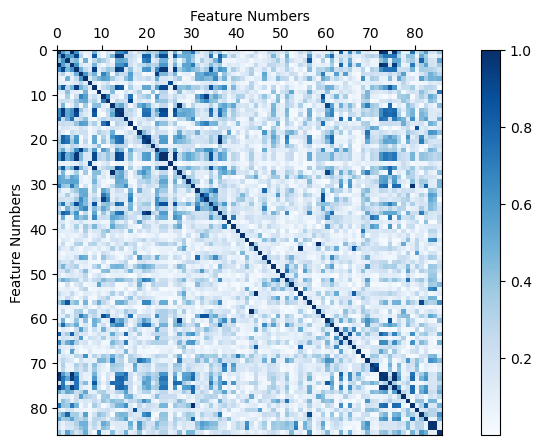

In [58]:
# before removing correlated features
fig1, ax1 = plt.subplots(figsize=(10,5))
c = ax1.pcolor(features_corr_df,cmap="Blues")
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.xaxis.set_ticks_position('top')
ax1.xaxis.set_label_position('top')
ax1.set_xlabel('Feature Numbers')
ax1.set_ylabel('Feature Numbers')
ax1.set_aspect('equal')
plt.colorbar(c,ax=ax1)
plt.show()

In [59]:
# Filter the features with correlation coefficients above 0.95
upper = features_corr_df.where(np.triu(np.ones(features_corr_df.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
features_df_lowcorr = features_df_noconstant.drop(columns=to_drop)
# recalculate the correlation matrix so we can compare
features_corr_df_update = features_df_lowcorr.corr(method="pearson").abs()

C:\Users\HP\AppData\Local\Temp\ipykernel_2540\3669307771.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = features_corr_df.where(np.triu(np.ones(features_corr_df.shape), k=1).astype(np.bool))


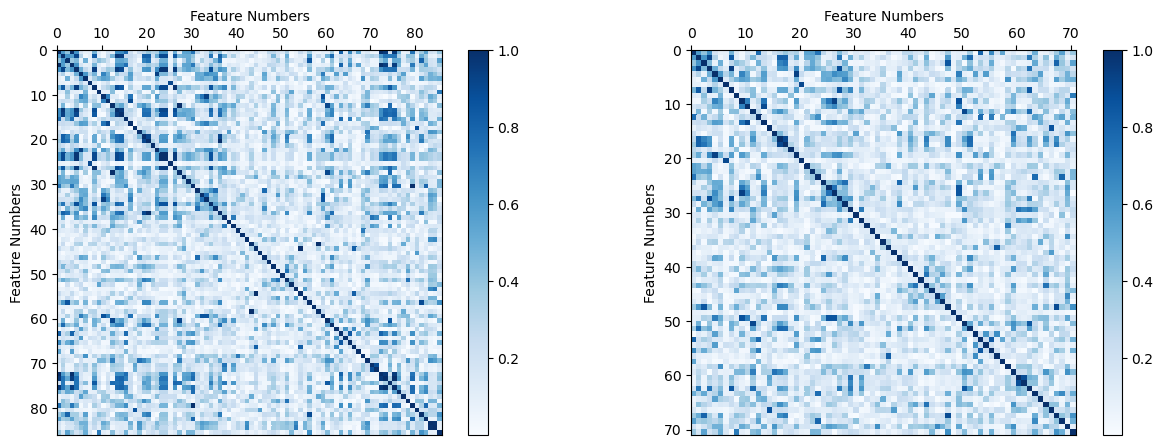

In [60]:
# plot correlation after removing highly correlated features

fig1, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
c1 = ax1.pcolor(features_corr_df,cmap="Blues")
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.xaxis.set_ticks_position('top')
ax1.xaxis.set_label_position('top')
ax1.set_xlabel('Feature Numbers')
ax1.set_ylabel('Feature Numbers')
ax1.set_aspect('equal')

plt.colorbar(c1,ax=ax1)

c2 = ax2.pcolor(features_corr_df_update,cmap="Blues")
ax2.set_ylim(ax2.get_ylim()[::-1])
ax2.xaxis.set_ticks_position('top')
ax2.xaxis.set_label_position('top')
ax2.set_xlabel('Feature Numbers')
ax2.set_ylabel('Feature Numbers')
ax2.set_aspect('equal')
plt.colorbar(c2,ax=ax2)
plt.show()

In [61]:
len(features_df_lowcorr.columns)

71

In [62]:
features_df_lowcorr

,AtomicNumber_composition_average,AtomicRadii_composition_average,AtomicVolume_composition_average,BCCefflatcnt_composition_average,BCCenergy_pa_composition_average,BCCfermi_composition_average,BCCmagmom_composition_average,BCCvolume_pa_composition_average,BCCvolume_padiff_composition_average,BoilingT_composition_average,...,NsValence_composition_average,Polarizability_composition_average,SecondIonizationEnergy_composition_average,ShearModulus_composition_average,SpaceGroupNumber_composition_average,ThermalConductivity_composition_average,ThermalExpansionCoefficient_composition_average,ThirdIonizationEnergy_composition_average,n_ws^third_composition_average,valence_composition_average
0,6.000000,1.135000,9311.576313,5.772386,-1.346741,-0.679877,0.0,12.4700,-0.680417,849.940000,...,1.50,12.446000,55.804000,2.100000,122.00,42.363950,923.000000,92.579000,0.490000,1.000000
1,10.000000,1.270000,9169.525548,6.658641,-1.410040,1.219961,0.0,18.5250,-2.020417,926.980000,...,1.50,13.257500,50.224000,2.100000,146.50,42.354450,23.000000,81.031000,0.490000,4.000000
2,19.000000,1.345000,32.035942,6.919518,-1.432083,1.117212,0.0,21.0350,-2.001667,973.500000,...,1.50,13.692500,49.219000,2.100000,146.50,42.411000,23.000000,79.225500,0.490000,4.000000
3,15.000000,1.560000,23.705899,6.704252,-2.371630,2.267697,0.0,19.1550,-1.180000,1676.250000,...,1.25,19.901250,61.611000,8.150000,213.25,69.600000,37.250000,98.163250,1.050000,2.000000
4,28.000000,1.440000,32.101458,7.343549,-1.459519,2.360221,0.0,25.9350,-3.869167,1036.150000,...,1.50,14.680000,47.884500,2.100000,146.50,42.574500,66.500000,77.725500,0.490000,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,60.500000,1.422500,40.865008,8.158525,-1.763974,5.485714,0.0,33.9975,-6.501250,802.225000,...,2.00,3.868750,18.520000,3.000000,51.00,2.304250,68.600000,31.139750,0.290000,6.500000
463,83.000000,1.700000,35.483459,7.821898,-3.895384,8.463157,0.0,29.9100,-3.040000,1837.000000,...,2.00,0.400000,16.687000,12.000000,12.00,7.870000,13.400000,25.559000,1.160000,5.000000
464,35.333333,1.086000,12405.753339,5.956046,-4.062017,4.524067,0.0,15.8700,-0.990000,1757.733333,...,2.00,11.234667,27.246000,10.333333,83.00,18.178267,523.666667,43.290333,0.426667,2.666667
465,50.000000,1.057500,9306.473007,5.880448,-6.738583,8.971338,0.0,13.7800,-0.785000,2145.050000,...,2.00,12.851000,17.558500,55.500000,37.50,13.933700,396.950000,27.467000,0.755000,4.000000


In [63]:
minmax_features = MinMaxScaler().fit_transform(features_df_lowcorr)
minmax_features_df = pd.DataFrame(minmax_features,columns=features_df_lowcorr.columns)
minmax_features_df.iloc[:5, :5]

,AtomicNumber_composition_average,AtomicRadii_composition_average,AtomicVolume_composition_average,BCCefflatcnt_composition_average,BCCenergy_pa_composition_average
0,0.012821,0.190923,0.583946,0.176111,0.893262
1,0.064103,0.275430,0.575030,0.310002,0.884705
2,0.179487,0.322379,0.001553,0.349415,0.881725
3,0.128205,0.456964,0.001030,0.316893,0.754709
4,0.294872,0.381847,0.001557,0.413475,0.878016


In [64]:
X = minmax_features_df                         # inputs/features 
y = target_data_df["Band gap values Clean"] # outputs/targets

For this purpose, I will restrict myself to five well-known materials with known bandgap values - Si, SiO2, C, NaCl, and Sn - and exclude them from the dataset. This way, I can validate my predictions and demonstrate the effectiveness of machine learning without having to manufacture and measure the material in the laboratory.

In [65]:
# Find prediction compounds and generate inputs for them to make predictions later.
def extract_predictions(formula="string"):
    index_prediction = target_data_df[target_data_df["chemicalFormula Clean"]==formula].index
    xpredict = X.loc[index_prediction].copy()
    ypredict = y.loc[index_prediction]
    
    return (index_prediction,xpredict,ypredict)

In [66]:
index_predict_Si, xpredict_Si, ypredict_Si = extract_predictions(formula="Si")
index_predict_SiO2, xpredict_SiO2, ypredict_SiO2 = extract_predictions(formula="Si1O2")
index_predict_C, xpredict_C, ypredict_C = extract_predictions(formula="C")
index_predict_Sn, xpredict_Sn, ypredict_Sn = extract_predictions(formula="Sn")
index_predict_NaCl, xpredict_NaCl, ypredict_NaCl = extract_predictions(formula="Na1Cl1")

X_predict = X.drop(index=index_predict_Si.to_list()+index_predict_SiO2.to_list()+index_predict_C.to_list()+index_predict_Sn.to_list()+index_predict_NaCl.to_list())
y_predict = y.drop(index=index_predict_Si.to_list()+index_predict_SiO2.to_list()+index_predict_C.to_list()+index_predict_Sn.to_list()+index_predict_NaCl.to_list())

In [67]:
# Generate train/test split by reserving 10% of data as test set

test_fraction = 0.1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_fraction, shuffle=True,random_state=seed)

C:\Users\HP\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


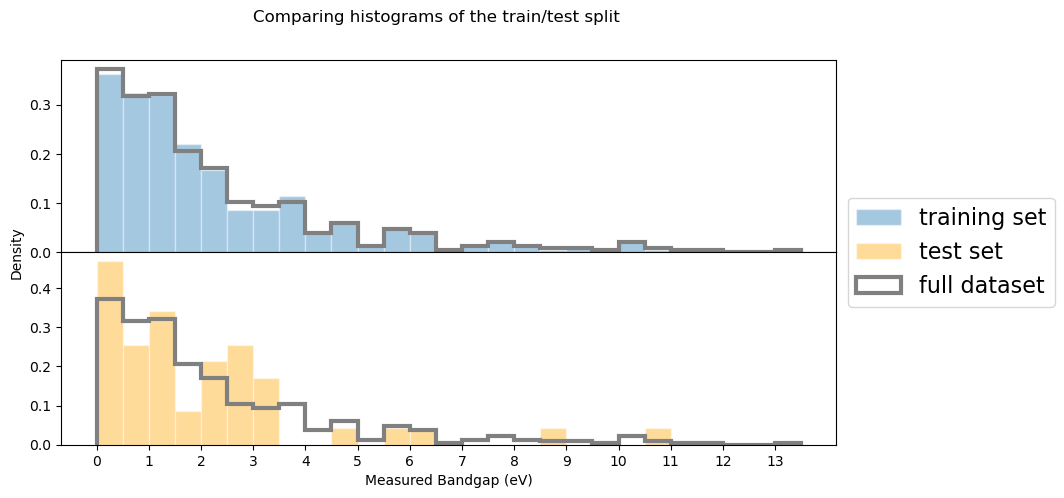

In [69]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,5), sharex = True, gridspec_kw={'hspace': 0})
fig.set_tight_layout(False)
myarray = ope_df_clean["bg"]

bins = np.true_divide(range(28),2)

l1 = sns.distplot(y_train.astype("float"), hist = True, norm_hist = True, kde = False, bins = bins, hist_kws={"edgecolor": "white"}, label = 'training set', ax = ax1)
l2 = sns.distplot(y_test.astype("float"), hist = True, norm_hist = True, kde = False, bins = bins, hist_kws={"edgecolor": "white", "color": "orange"}, label = 'test set', ax = ax2)
l3 = sns.distplot(myarray, hist = True, norm_hist = True, kde = False, bins = bins, hist_kws={"histtype": "step","linewidth": 3, "alpha": 1, "color": "grey"}, ax = ax1)
l4 = sns.distplot(myarray, hist = True, norm_hist = True, kde = False, bins = bins, hist_kws={"histtype": "step","linewidth": 3, "alpha": 1, "color": "grey"}, label = 'full dataset', ax = ax2)


ax1.set_xticks(range(14))
ax2.set_xticks(range(14))
ax2.xaxis.label.set_visible(False)
handles, labels = [(a + b) for a, b in zip(ax1.get_legend_handles_labels(), ax2.get_legend_handles_labels())]
fig.suptitle('Comparing histograms of the train/test split')
fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.legend(handles, labels, loc = 'center left', bbox_to_anchor=(1, 0.5),prop={'size': 16})
plt.xlabel('Measured Bandgap (eV)')
_ = plt.ylabel('Density')

In [70]:
Default_model = RandomForestRegressor(random_state=seed,n_estimators=1,bootstrap=False).fit(X_train,y_train) # fit the decision tree model
print('Model training complete.')
# print('Tree depth:', [estimator.tree_.max_depth for estimator in Default_model.estimators_])
# for importance in zip (estimator.feature_importances_ for estimator in Default_model.estimators_):
#     print (importance)
#print('Leaf nodes:',[estimator.tree_.n_leaves for estimator in Default_model.estimators_])

Model training complete.


I'll train the decision tree model using the RandomForestRegressor().fit(). The reason I'll use it is because it will later give more flexibility when I start changing the model.

In [71]:
Default_model_all_data = RandomForestRegressor(random_state=seed,n_estimators=1,bootstrap=False).fit(X_predict,y_predict)

print("Predicting Silicon Band Gap: ",Default_model_all_data.predict(xpredict_Si))

print("Predicting Silica Band Gap: ",Default_model_all_data.predict(xpredict_SiO2))

Predicting Silicon Band Gap:  [2.]
Predicting Silica Band Gap:  [6.]


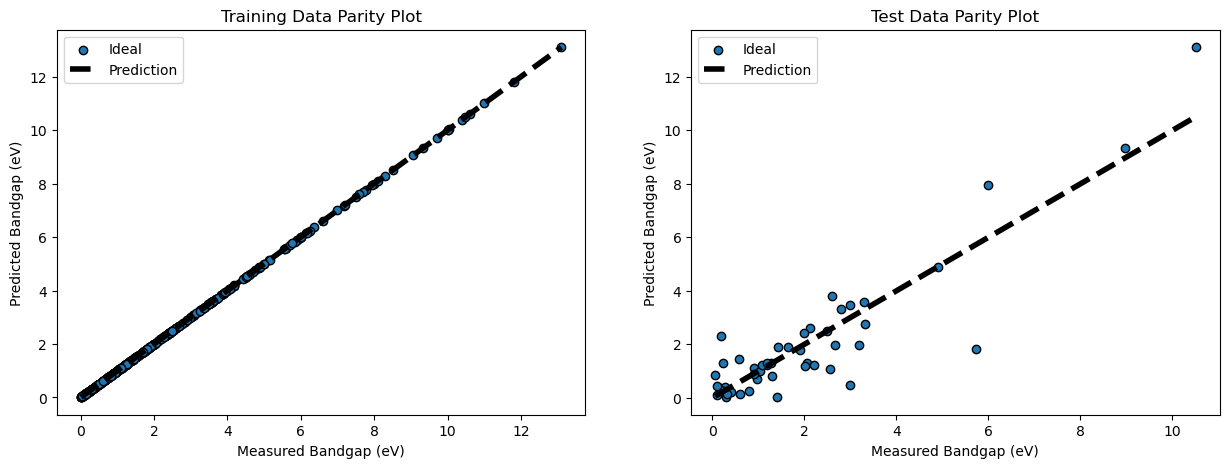

,Error Metric,Training Data,Test Data,Note
0,RMSE,0.0003 (eV),1.0492 (eV),(0.0 for perfect prediction)
1,RMSE/std,0.0001,0.4884,(0.0 for perfect prediction)
2,MAE,0.0 (eV),0.6811 (eV),(0.0 for perfect prediction)
3,R2,1.0,0.7614,(1.0 for perfect prediction)


In [72]:
Train_predictions = Default_model.predict(X_train)    # Make predictions on training data
Test_predictions = Default_model.predict(X_test)      # Make predictions on testing data

parity_plots_side_by_side(y_train,Train_predictions,y_test,Test_predictions,title_left="Training Data Parity Plot",title_right="Test Data Parity Plot") # build both plots
parity_stats_side_by_side(y_train,Train_predictions,y_test,Test_predictions,"Training Data","Test Data")  # print error metrics for training data

In [73]:
#Improving the Model by Optimizing Hyperparameter
print('Default model uses the following hyperparameters:\n') # print default hyperparameters used
pprint(Default_model.get_params())

Default model uses the following hyperparameters:

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 2345312,
 'verbose': 0,
 'warm_start': False}


In [74]:
# set up hyperparameter grid (a dictionary of hyperparameter candidates that we want the optimization strategy to consider)

# EDIT LIST TO TRY DIFFERENT VALUES!
### MAKE EDITS BELOW HERE ###
number_of_trees = [1,10,25,50]
### MAKE EDITS ABOVE HERE ###

opt_dict = {'n_estimators':number_of_trees,'bootstrap':['True']}

In [75]:
# kfold = KFold(n_splits=5,random_state=seed,shuffle=True)
kfold = RepeatedKFold(n_splits=5,
                      random_state=seed,
                      n_repeats=5)

In [76]:
# define a grid search strategy

import time

CV = GridSearchCV(Default_model, # 1. the model whose hyperparamter is being optimized right now
                  opt_dict,   # 2. a dictionary of values that we want the grid search to use
                  cv=kfold,   # 4. k-fold cross-validation strategy is used to define training and validation splits (note this is separate from test splits) to be used for each grid point
                  return_train_score=True,
                  scoring=['neg_mean_squared_error','r2','neg_mean_absolute_error'], # 5. the performance metrics to be reported at each grid point specified in opt_dict
                  refit='neg_mean_squared_error')

# perform grid search
tic = time.perf_counter() # start timer

CV = CV.fit(X_train,y_train)

toc = time.perf_counter() # stop timer

# print results
print(f"Grid search completed in {toc - tic:0.3f} seconds.")
print(CV.best_params_)

Grid search completed in 25.362 seconds.
{'bootstrap': 'True', 'n_estimators': 50}


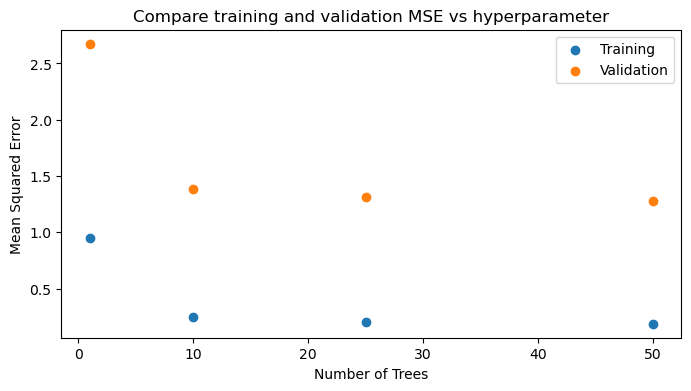

Minimum Mean Squared Error:  1.2795
Number of Trees at minimum:  50


In [77]:
# plot number of trees vs train and test MSE

opt_dict_array = opt_dict["n_estimators"]                     # array of grid points (x-axis)
train_mse = CV.cv_results_["mean_train_neg_mean_squared_error"] # MSE of training set at each grid point (y-axis)
test_mse = CV.cv_results_["mean_test_neg_mean_squared_error"]   # MSE of test set at each grid point (y-axis)

fig1,ax1 = plt.subplots(figsize=(8,4))
ax1.scatter(opt_dict_array, -train_mse)
ax1.scatter(opt_dict_array, -test_mse)
# ax1.fill_between(opt_dict_array, -train_mse, -test_mse, alpha=0.1)
ax1.set_xlabel('Number of Trees')
ax1.set_ylabel('Mean Squared Error')
ax1.set_title('Compare training and validation MSE vs hyperparameter')
plt.legend(["Training","Validation","difference"])
plt.show()
print("Minimum Mean Squared Error: ", round(min(-test_mse),4))
print("Number of Trees at minimum: ", opt_dict_array[np.argmin(-test_mse)])

In [78]:
# check what the best parameters identified in the grid search were
CV.best_params_

{'bootstrap': 'True', 'n_estimators': 50}

In [79]:
# Extract cross validation performance metrics for the optimized model
opt_CV_stats = CV_best_stats(CV,y_train)

Average test RMSE:  1.1311 (0.0 for perfect prediction)
Average test RMSE/std:  0.4922 (0.0 for perfect prediction)
Average test MAE:  0.7632 (0.0 for perfect prediction)
Average test R2:  0.7488 (1.0 for perfect prediction)


In [80]:
default_opt_dict = {'n_estimators':[1]}

default_CV = GridSearchCV(Default_model,
                          default_opt_dict,
                          cv=kfold,
                          return_train_score=True,
                          scoring=['neg_mean_squared_error','r2','neg_mean_absolute_error'],
                          refit='neg_mean_squared_error')
default_CV = default_CV.fit(X_train,y_train)

default_CV_stats = CV_best_stats(default_CV,y_train)

Average test RMSE:  1.4691 (0.0 for perfect prediction)
Average test RMSE/std:  0.6393 (0.0 for perfect prediction)
Average test MAE:  0.9779 (0.0 for perfect prediction)
Average test R2:  0.5774 (1.0 for perfect prediction)


In [81]:
# Refit the model using the best hyperparameters
DT2 = CV.best_estimator_.fit(X_train,y_train)

# predict both the train and test data
Train_predictions2 = DT2.predict(X_train)
Test_predictions2 = DT2.predict(X_test)

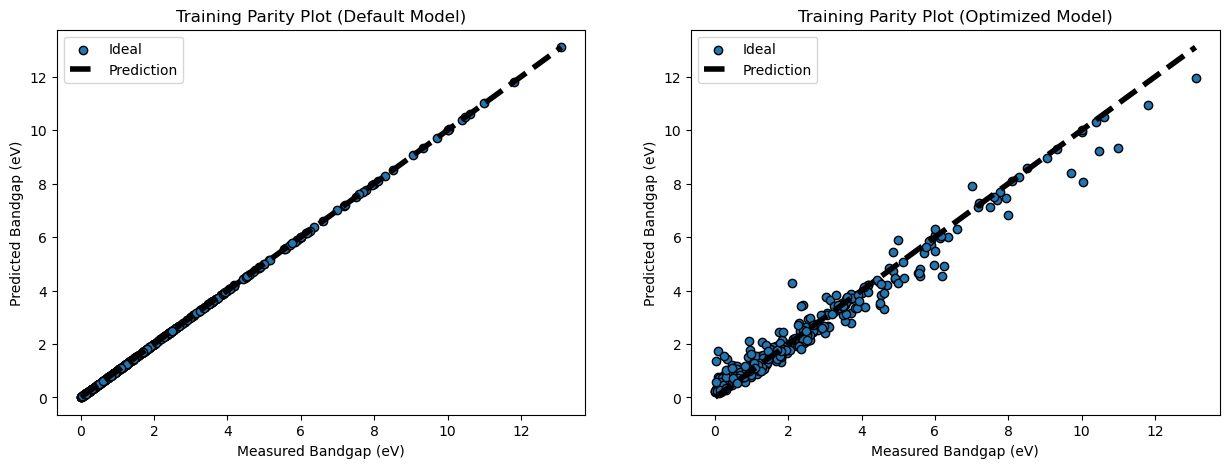

,Error Metric,Training Set (Default Model),Training Set (Optimized Model),Note
0,RMSE,0.0003 (eV),0.4226 (eV),(0.0 for perfect prediction)
1,RMSE/std,0.0001,0.1839,(0.0 for perfect prediction)
2,MAE,0.0 (eV),0.274 (eV),(0.0 for perfect prediction)
3,R2,1.0,0.9662,(1.0 for perfect prediction)


In [82]:
parity_plots_side_by_side(y_train,Train_predictions,y_train,Train_predictions2,title_left="Training Parity Plot (Default Model)",title_right="Training Parity Plot (Optimized Model)") # build both plots
parity_stats_side_by_side(y_train,Train_predictions,y_train,Train_predictions2,"Training Set (Default Model)","Training Set (Optimized Model)")

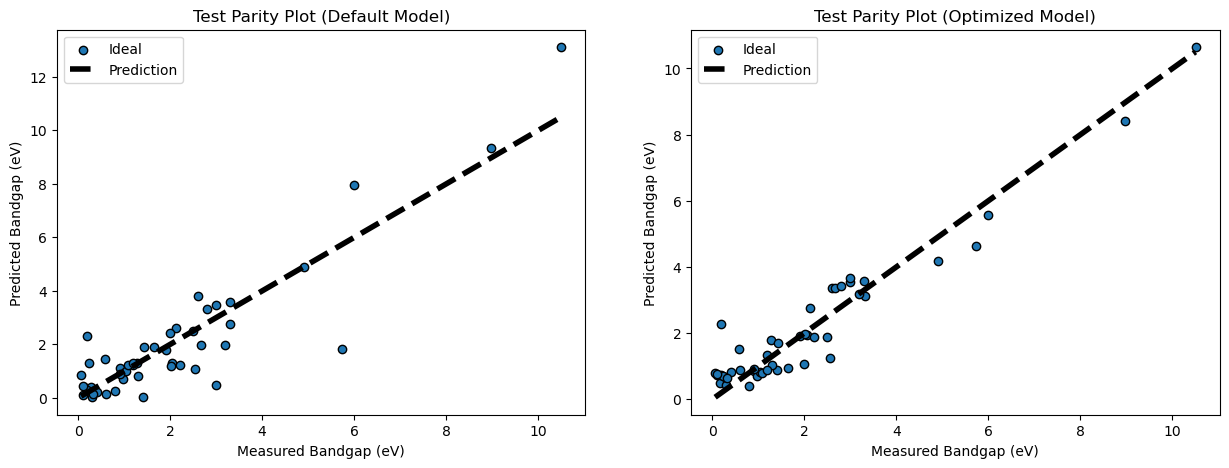

,Error Metric,Test Set (Default Model),Test Set (Optimized Model),Note
0,RMSE,1.0492 (eV),0.6062 (eV),(0.0 for perfect prediction)
1,RMSE/std,0.4884,0.2822,(0.0 for perfect prediction)
2,MAE,0.6811 (eV),0.4776 (eV),(0.0 for perfect prediction)
3,R2,0.7614,0.9204,(1.0 for perfect prediction)


In [83]:
parity_plots_side_by_side(y_test,Test_predictions,y_test,Test_predictions2, title_left="Test Parity Plot (Default Model)",title_right="Test Parity Plot (Optimized Model)") # build both plots
parity_stats_side_by_side(y_test,Test_predictions,y_test,Test_predictions2,"Test Set (Default Model)","Test Set (Optimized Model)")

In [84]:
# fit model to all data except for the values we want to predict.
DT3 = CV.best_estimator_.fit(X_predict,y_predict)

In [85]:
### MAKE EDITS BELOW HERE ###

Prediction_features = xpredict_Si

### MAKE EDITS ABOVE HERE ###

# make a prediction with the trained DT3 model
print("Predicted Band Gap: ",DT3.predict(Prediction_features))

Predicted Band Gap:  [1.4877]


In [86]:
# combine previous data into one dataframe for visualization
predictions_combined = pd.DataFrame(list(zip(y_test,Test_predictions2)),columns=['test','predictions'])

In [87]:
# sort on the Test values from low to high
predictions_combined.sort_values("test")

,test,predictions
31,0.064,0.790620
39,0.100,0.769340
10,0.100,0.725600
0,0.170,0.494000
21,0.200,2.284800
20,0.200,0.743690
37,0.230,0.700720
7,0.270,0.668420
9,0.310,0.421760
43,0.332,0.635540
